# Pretrained Models

## Base learners using pretrained models

### Base learners using Resnet152, AlexNet, Densenet161

Built using the function that Tyler created
The tb_preprocess.py script should be in the same folder as the notebook.

##### Need to add other models

In [1]:
modelnames = {'alexnet':'alexnet','resnet152':'resnet152','densenet161':'densenet161', 'vgg19':'vgg19'}

#Set the Model name
model_param = 'vgg19'
filepath = '.'

{'covid-19': 0, 'normal': 1, 'pnuemonia': 2}


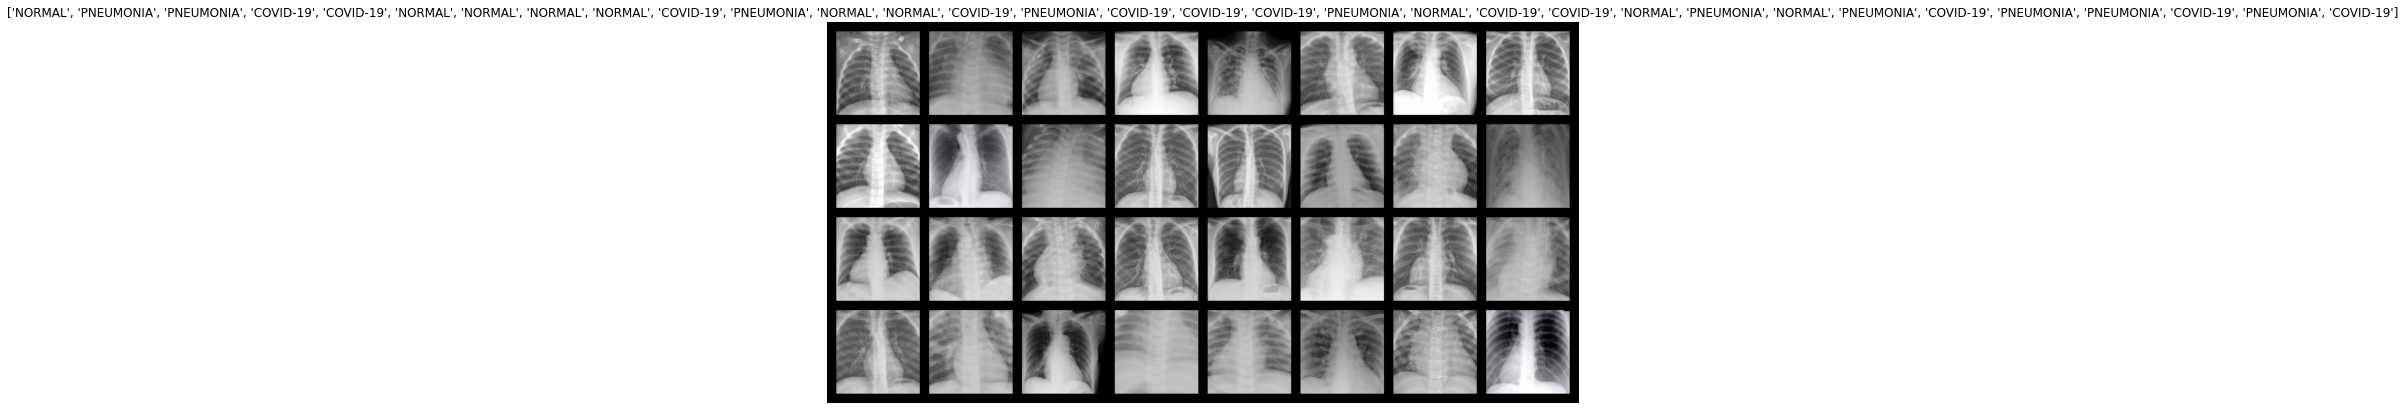

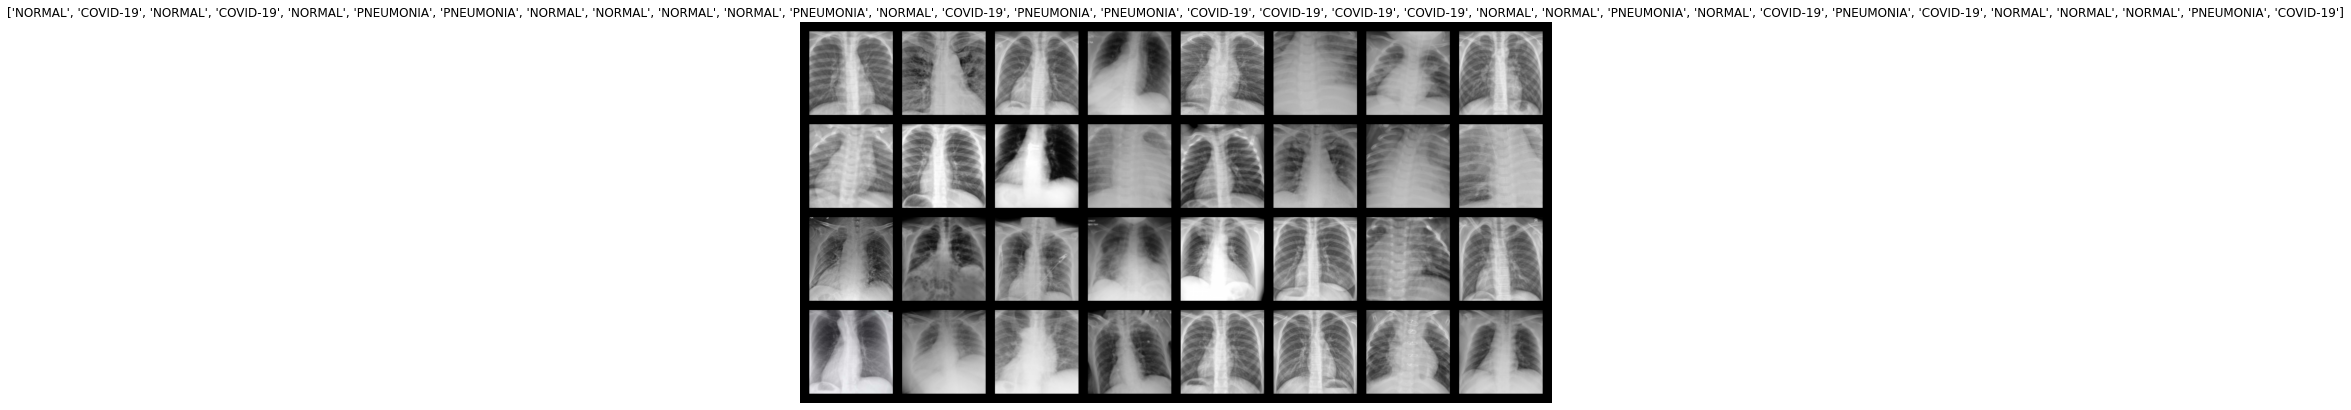

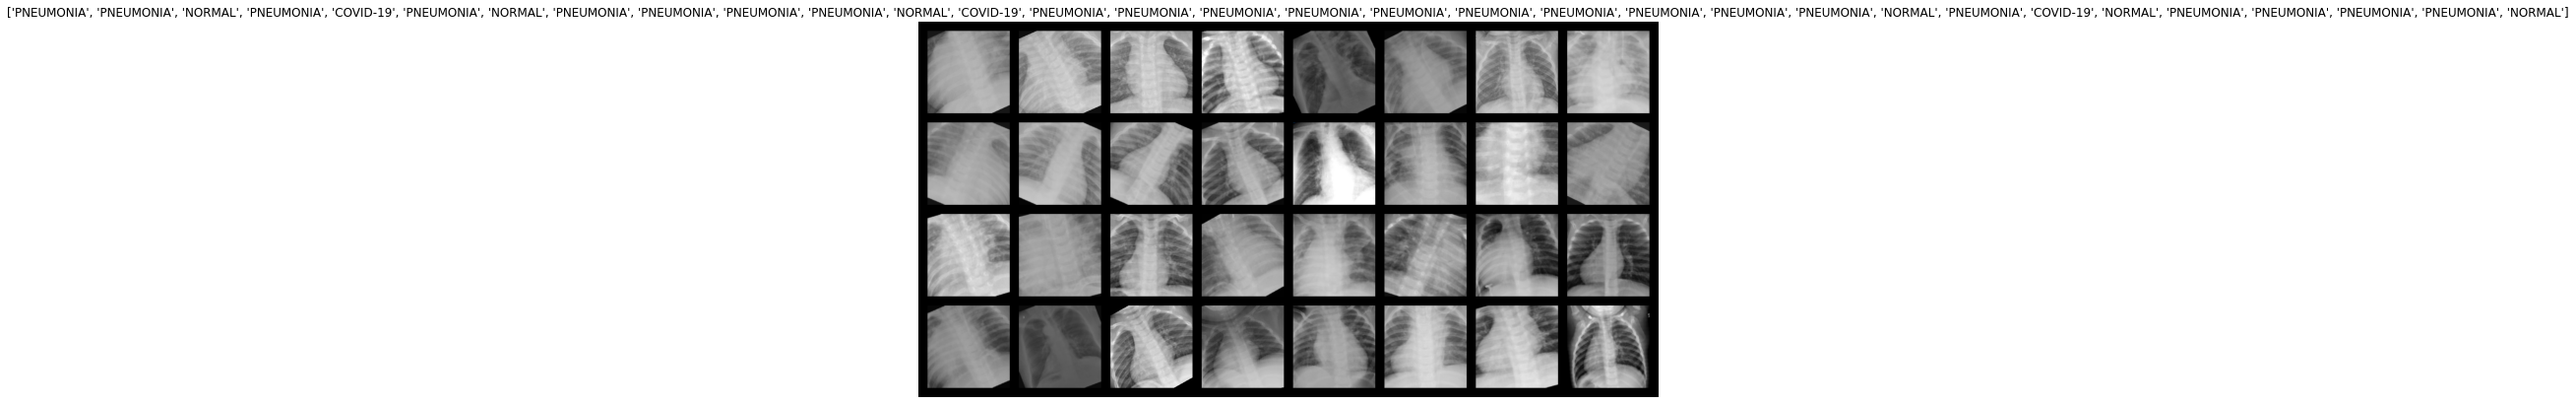

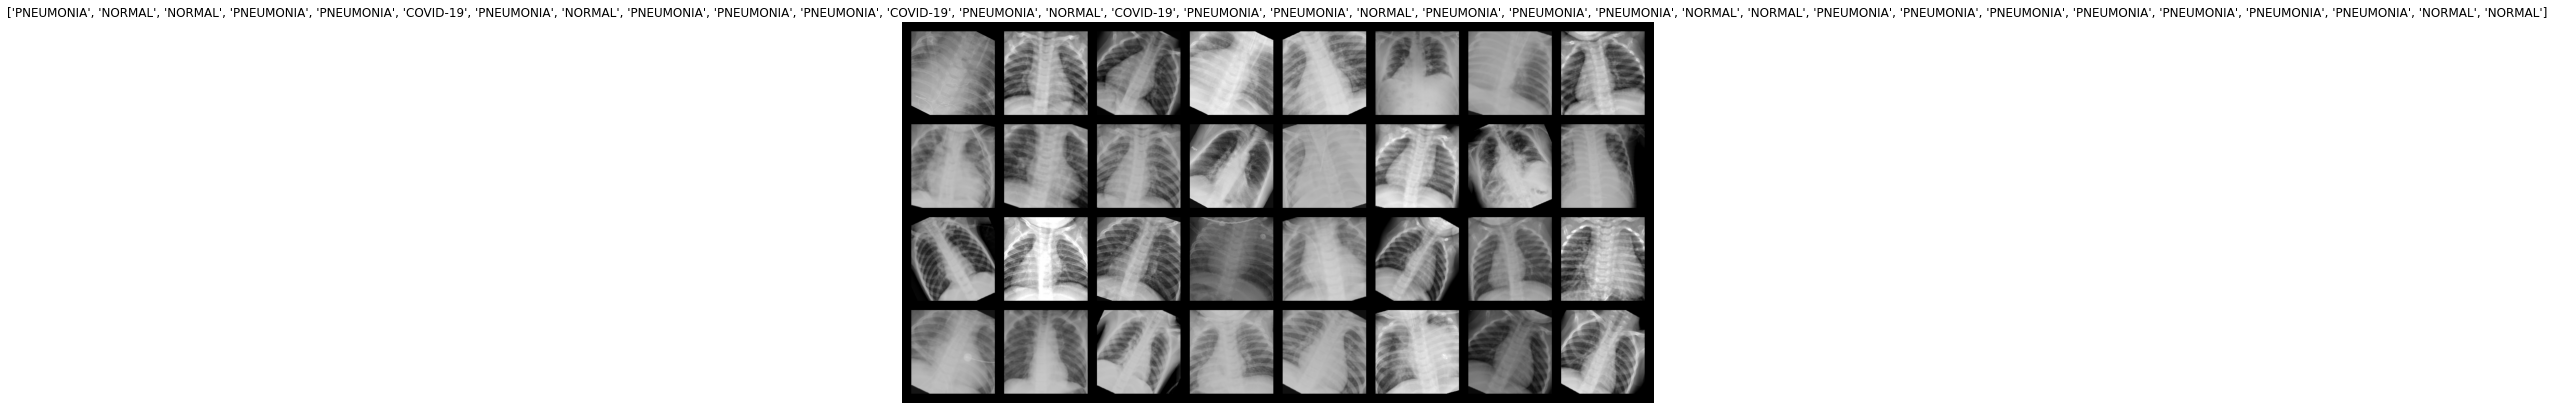

{'covid-19': 0, 'normal': 1, 'pnuemonia': 2}


In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time; _START_RUNTIME = time.time()
import gc


from torchvision import models


#Use the preprocess function from tb_preprocess.py to load the datasets
from tb_preprocess import load_data

train_loader, val_loader, train_loader_red, val_loader_red = load_data() 
  
tloader = train_loader_red;
vloader = val_loader_red;
    
idx2class = {'covid-19': 0, 'normal': 1, 'pnuemonia': 2}
classes = ('Covid-19', 'Normal', 'Pneumonia')



### Use the model that is pretrained. 

##### Model selection is hardcoded for now


In [3]:
gc.collect()
torch.cuda.empty_cache()


red_model = models.__dict__[model_param](pretrained=True)

#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

#Move the input and model to GPU for speed if available
red_model.to(device)


cuda:0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

#### Change the last linear layer to match the number of classes. In this case 3.

##### Eg:- The standard Alexnet model has 1000 out features for the last Linear layer. Since the data set only has 3 classes, change the last layer to have 3 outs

In [4]:

if model_param == 'alexnet':
    red_model.classifier[6] = torch.nn.Linear(red_model.classifier[6].in_features, 3, bias=True)
elif model_param == 'resnet152':
    red_model.fc = torch.nn.Linear(2048, 3, bias=True)
elif model_param == 'densenet161':
    red_model.classifier = torch.nn.Linear(2208, 3, bias=True)
elif model_param == 'vgg19':
    red_model.classifier[6] = torch.nn.Linear(4096, 3, bias=True)

red_model.eval()


if model_param == 'alexnet':
    red_model.features = torch.nn.DataParallel(red_model.features)
    red_model.cuda()
else:
    red_model = torch.nn.DataParallel(red_model).cuda()
    

#### Criterion and Optimizer

In [5]:
import torch.optim as optim

#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(red_model.parameters(), lr=0.001, momentum=0.9)

### Training VGG19

In [6]:
#Epochs is set to 1. Performace is slow
#Need to try CUDA to speed up

n_epochs = 25

def train_model(model, train_dataloader, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):
    import torch.optim as optim

    # prep model for training
    model.train() 
    
    for epoch in range(n_epoch):
        
        EPOCH_START = time.time()
        
        curr_epoch_loss = []
        
        for data, target in train_dataloader:
            
            data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            
            output = model(data)
            #print(output)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            
            curr_epoch_loss.append(loss.cpu().data.numpy())
            
        print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
        print("Training time = {:.2f} seconds".format(time.time() - EPOCH_START))
    
    return model


### Save the model

In [7]:
trainedmodel = model_param + '.pth'

if os.path.exists(trainedmodel):
    print('Model is trained - ' + model_param)
    red_model = torch.load(trainedmodel)
else:
    red_model = train_model(red_model, tloader)
    torch.save(red_model, trainedmodel)
    print("Total running time = {:.2f} seconds".format(time.time() - _START_RUNTIME))
    
gc.collect()
torch.cuda.empty_cache()

    

Epoch 0: curr_epoch_loss=0.4112796485424042
Training time = 304.40 seconds
Epoch 1: curr_epoch_loss=0.24478082358837128
Training time = 224.20 seconds
Epoch 2: curr_epoch_loss=0.19891682267189026
Training time = 225.05 seconds
Epoch 3: curr_epoch_loss=0.1583370715379715
Training time = 223.61 seconds
Epoch 4: curr_epoch_loss=0.15043164789676666
Training time = 216.86 seconds
Epoch 5: curr_epoch_loss=0.13987940549850464
Training time = 208.91 seconds
Epoch 6: curr_epoch_loss=0.13221418857574463
Training time = 210.34 seconds
Epoch 7: curr_epoch_loss=0.12371919304132462
Training time = 208.44 seconds
Epoch 8: curr_epoch_loss=0.12478181719779968
Training time = 208.78 seconds
Epoch 9: curr_epoch_loss=0.1122349351644516
Training time = 222.75 seconds
Epoch 10: curr_epoch_loss=0.10073275864124298
Training time = 210.45 seconds
Epoch 11: curr_epoch_loss=0.10124336928129196
Training time = 238.39 seconds
Epoch 12: curr_epoch_loss=0.10374583303928375
Training time = 225.49 seconds
Epoch 13: cu

#### Testing

Validation Accuracy: 0.9620553359683794
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96        88
         1.0       0.92      0.95      0.93       319
         2.0       0.98      0.97      0.97       858

    accuracy                           0.96      1265
   macro avg       0.95      0.96      0.95      1265
weighted avg       0.96      0.96      0.96      1265

Confusion Matrix
[[ 85   0   3]
 [  3 303  13]
 [  2  27 829]]
Confusion Matrix Display


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass display_labels=('Covid-19', 'Normal', 'Pneumonia') as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


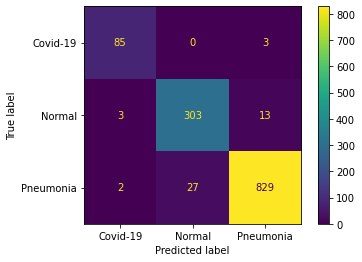

In [8]:
def eval_model(model, dataloader):

    model.eval()
    Y_pred = []
    Y_test = []
    for data, target in dataloader:

        data, target = data.cuda(), target.cuda()
        
        output = model(data)
        #print(output.data)
        #print(target)
        _, y_predicted = torch.max(output.data, 1)
        
        Y_pred = np.append(Y_pred,y_predicted.detach().cpu().numpy())
        Y_test = np.append(Y_test,target.detach().cpu().numpy())

    return Y_pred, Y_test

from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred, y_true = eval_model(red_model, vloader)
acc = accuracy_score(y_true, y_pred)

print(("Validation Accuracy: " + str(acc)))

# Classification Report
print(classification_report(y_true, y_pred))

# Confusion Matrix
print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_pred)).rename(columns=idx2class, index=idx2class)

cm = confusion_matrix(y_true, y_pred)
#print(cm)

print('Confusion Matrix Display')
cm_display = ConfusionMatrixDisplay(cm,classes).plot()


## Testing Accuracy

Classification accuracy of the test model.

In [9]:

correct = 0
total = 0

# no_grad impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations
with torch.no_grad():
    for data in vloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = red_model(images)
        #print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test X-rays : %d %%' % ( 100 * correct / total))



Accuracy of the network on test X-rays : 96 %


## Individual Classes


In [10]:
#Testing classification accuracy for individual classes.
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))

with torch.no_grad():
    for data in vloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = red_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
         classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of Covid-19 : 100 %
Accuracy of Normal : 100 %
Accuracy of Pneumonia : 96 %
